<a href="https://colab.research.google.com/github/hrifanov/ml_project/blob/main/Sprint_6/contrastive_loss_copy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install keras_vggface
!pip install keras_applications

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 KB 2.4 MB/s eta 0:00:00


In [ ]:
!pip show keras_vggface

Name: keras-vggface
Version: 0.6
Summary: VGGFace implementation with Keras framework
Home-page: https://github.com/rcmalli/keras-vggface
Author: Refik Can MALLI
Author-email: mallir@itu.edu.tr
License: MIT
Location: /usr/local/lib/python3.8/dist-packages
Requires: h5py, keras, numpy, pillow, pyyaml, scipy, six
Required-by: 


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import resnet50
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow import convert_to_tensor
import tensorflow.keras.backend as K
from matplotlib import pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import LeaveOneOut, KFold
import keras
from keras.models import load_model
from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input
import pandas as pd
import numpy as np
import cv2
import os
import random

In [ ]:
images_path = "drive/MyDrive/Dataset/img_celeba_cropped/"
celeb = "drive/MyDrive/Dataset/colab_df.txt"
openface = "/content/drive/MyDrive/openface/nn4.small2.v1.t7"

In [ ]:
image_shape=(224, 224, 3)

batch_size=16
lr=0.00001

In [ ]:
balanced_df = pd.read_csv(celeb)
balanced_df["left"] = balanced_df["left"].str.replace("../Dataset/img_celeba_cropped/", "drive/MyDrive/Dataset/img_celeba_cropped/")
balanced_df["right"] = balanced_df["right"].str.replace("../Dataset/img_celeba_cropped/", "drive/MyDrive/Dataset/img_celeba_cropped/")
balanced_df

<ipython-input-4-ae9cb30fda96>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  balanced_df["left"] = balanced_df["left"].str.replace("../Dataset/img_celeba_cropped/", "drive/MyDrive/Dataset/img_celeba_cropped/")
<ipython-input-4-ae9cb30fda96>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  balanced_df["right"] = balanced_df["right"].str.replace("../Dataset/img_celeba_cropped/", "drive/MyDrive/Dataset/img_celeba_cropped/")


,left,right,label
0,drive/MyDrive/Dataset/img_celeba_cropped/00497...,drive/MyDrive/Dataset/img_celeba_cropped/00237...,1
1,drive/MyDrive/Dataset/img_celeba_cropped/00497...,drive/MyDrive/Dataset/img_celeba_cropped/00231...,0
2,drive/MyDrive/Dataset/img_celeba_cropped/00310...,drive/MyDrive/Dataset/img_celeba_cropped/00094...,1
3,drive/MyDrive/Dataset/img_celeba_cropped/00310...,drive/MyDrive/Dataset/img_celeba_cropped/00374...,0
4,drive/MyDrive/Dataset/img_celeba_cropped/00474...,drive/MyDrive/Dataset/img_celeba_cropped/00482...,1
...,...,...,...
1195,drive/MyDrive/Dataset/img_celeba_cropped/00070...,drive/MyDrive/Dataset/img_celeba_cropped/00160...,0
1196,drive/MyDrive/Dataset/img_celeba_cropped/00182...,drive/MyDrive/Dataset/img_celeba_cropped/00325...,1
1197,drive/MyDrive/Dataset/img_celeba_cropped/00182...,drive/MyDrive/Dataset/img_celeba_cropped/00301...,0
1198,drive/MyDrive/Dataset/img_celeba_cropped/00487...,drive/MyDrive/Dataset/img_celeba_cropped/00243...,1


In [ ]:
train_df, test_df, validate_df = np.split(balanced_df, [int(.8*len(balanced_df)), int(.9*len(balanced_df))])

In [ ]:
X_train = train_df[["left", "right"]]
Y_train_label = train_df[["label"]]

X_test = test_df[["left", "right"]]
Y_test_label = test_df[["label"]]

X_val = validate_df[["left", "right"]]
Y_val_label = validate_df[["label"]]

In [ ]:
print('=====Training=====')
print(X_train.shape)
print(Y_train_label.shape)

print('=====Testing=====')
print(X_test.shape)
print(Y_test_label.shape)

print('=====Validate=====')
print(X_val.shape)
print(Y_val_label.shape)

=====Training=====
(960, 2)
(960, 1)
=====Testing=====
(120, 2)
(120, 1)
=====Validate=====
(120, 2)
(120, 1)


In [ ]:
#def preprocessing(left, right):
def preprocessing(img):
    #return convert_to_img(left), convert_to_img(right)
    return convert_to_img(img)


def convert_to_img(img_path):
    img = cv2.imread(img_path)
    img = img.astype("float32")
    img = preprocess_input(img, version=2)

    return img

def label_preprocessing(label):
    return tf.cast(label, tf.float32)

In [ ]:
def create_dataset(features, labels):

    left = features["left"].apply(convert_to_img)
    right = features["right"].apply(convert_to_img)
    left = left.tolist()
    right = right.tolist()

    feature_ds = tf.data.Dataset.from_tensor_slices((left, right))
    labels_ds = tf.data.Dataset.from_tensor_slices(labels.values)
    
    labels_ds = labels_ds.map(label_preprocessing)
    
    dataset = tf.data.Dataset.zip((feature_ds, labels_ds))
    dataset = dataset.batch(batch_size, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return dataset

In [ ]:
train_ds = create_dataset(X_train, Y_train_label)
test_ds = create_dataset(X_test, Y_test_label)
val_ds = create_dataset(X_val, Y_val_label)
train_ds

<PrefetchDataset element_spec=((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

In [ ]:
left_input = layers.Input(shape=image_shape, name='left_input')
right_input = layers.Input(shape=image_shape, name='right_input')

In [ ]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))

In [ ]:
def tower_network():
  input = layers.Input((image_shape))
  scaled_input = layers.Rescaling(1/255, 0.0)(input)

  x = layers.Conv2D(32, (10, 10), activation="relu", padding="same")(scaled_input)
  x = layers.MaxPool2D((2, 2))(x)

  x = layers.Conv2D(64, (5, 5), activation="relu", padding="same")(x)
  x = layers.MaxPool2D((2, 2))(x)

  x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
  x = layers.MaxPool2D((2, 2))(x)

  x = layers.GlobalAveragePooling2D()(x)

  x = layers.Flatten()(x)
  output = layers.Dense(64, activation="relu")(x)
  
  return Model(inputs=input, outputs=output, name="tower_network")

In [ ]:
def vgg_face_tower():
  input = layers.Input((image_shape))
  base = VGGFace(input_tensor = input, model="resnet50", input_shape=image_shape, include_top = False)

  for layer in base.layers:
    layer.trainable = False

  for layer in base.layers:
    print(layer.name, layer.trainable)

  x = layers.Flatten()(base.output)
  output = layers.Dense(64, activation="relu")(x)

  return Model(input, output, name="vgg_face_tower")

In [ ]:
features_extractor = vgg_face_tower()

In [ ]:
# initializing the left "tower"
left_tower_input = layers.Input(shape=(224,224,3), name = "left_tower")
left_tower = features_extractor(left_tower_input)
# initializing the right "tower"
right_tower_input = layers.Input(shape=(224,224,3), name = "right_tower")
right_tower = features_extractor(right_tower_input)
# merge, normalize, and output
merge_layer = layers.Lambda(euclidean_distance, name = "lambda_layer")([left_tower, right_tower])
    
x = layers.Dense(64, activation = "relu")(merge_layer)
    
output_layer = layers.Dense(1, activation = "sigmoid")(x)
    
model = Model([left_tower_input, right_tower_input], output_layer, name = "siamese_lambda_network")

In [ ]:
def cont_loss(margin=1):
    def contrastive_loss(y_true, y_pred):
        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

    return contrastive_loss

In [ ]:
model.compile(loss=cont_loss(0.2), optimizer=Adam(learning_rate=lr))
model.summary()

Model: "siamese_lambda_network"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 left_tower (InputLayer)        [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 right_tower (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg_face_tower (Functional)    (None, 64)           23692288    ['left_tower[0][0]',             
                                                                  'right_towe

In [ ]:
callback_list = []

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5)
callback_list.append(early_stopping)

In [ ]:
model_fit = model.fit(train_ds, validation_data=val_ds, epochs=15, callbacks=callback_list)

Epoch 1/15
60/60 [==============================] - 12s 121ms/step - loss: 0.0149 - val_loss: 0.0133
Epoch 2/15
60/60 [==============================] - 6s 100ms/step - loss: 0.0128 - val_loss: 0.0108
Epoch 3/15
60/60 [==============================] - 6s 101ms/step - loss: 0.0103 - val_loss: 0.0082
Epoch 4/15
60/60 [==============================] - 6s 102ms/step - loss: 0.0081 - val_loss: 0.0068
Epoch 5/15
60/60 [==============================] - 6s 105ms/step - loss: 0.0069 - val_loss: 0.0064
Epoch 6/15
60/60 [==============================] - 6s 103ms/step - loss: 0.0064 - val_loss: 0.0063
Epoch 7/15
60/60 [==============================] - 6s 102ms/step - loss: 0.0061 - val_loss: 0.0062
Epoch 8/15
60/60 [==============================] - 6s 101ms/step - loss: 0.0058 - val_loss: 0.0062
Epoch 9/15
60/60 [==============================] - 6s 101ms/step - loss: 0.0055 - val_loss: 0.0061
Epoch 10/15
60/60 [==============================] - 6s 104ms/step - loss: 0.0053 - val_loss: 0.006

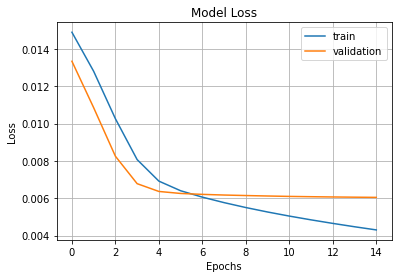

In [ ]:
plt.plot(model_fit.history['loss'])
plt.plot(model_fit.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.grid()

plt.show()

In [ ]:
def create_dataset_no_labels(features):
    left = features["left"].apply(convert_to_img)
    right = features["right"].apply(convert_to_img)
    left = left.tolist()
    right = right.tolist()

    feature_ds = tf.data.Dataset.from_tensor_slices((left, right))
    
    feature_ds = feature_ds.batch(batch_size, num_parallel_calls=tf.data.AUTOTUNE)
    feature_ds = feature_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return feature_ds

def create_singular_dataset(feature):
    dataset = tf.data.Dataset.from_tensor_slices(feature.values)
    dataset = dataset.map(convert_to_img)
    dataset = dataset.batch(batch_size, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return dataset

In [ ]:
#test_ds_left = create_singular_dataset(X_test['left'])
#test_ds_right = create_singular_dataset(X_test['right'])
test_labels = Y_test_label['label']

#test_ds_full = create_dataset_no_labels(X_test)

In [ ]:
predictions = model.predict(test_ds)

8/8 [==============================] - 2s 95ms/step


In [ ]:
predictions_for_accuracy = predictions.flatten()
predictions_for_accuracy = predictions_for_accuracy.tolist()

In [ ]:
len(predictions_for_accuracy)

120

In [ ]:
predictions_labels = pd.DataFrame({"labels":test_labels, 
                                   "predictions":predictions_for_accuracy})
predictions_labels

,labels,predictions
960,1,0.138251
961,0,0.032759
962,1,0.185583
963,0,0.060183
964,1,0.186434
...,...,...
1075,0,0.079032
1076,1,0.131266
1077,0,0.057131
1078,1,0.183774


In [ ]:
predictions_labels_positive = predictions_labels["predictions"].loc[predictions_labels["labels"] == 1]
predictions_labels_negative = predictions_labels["predictions"].loc[predictions_labels["labels"] == 0]
positive_mean = predictions_labels_positive.mean()
negative_mean = predictions_labels_negative.mean()

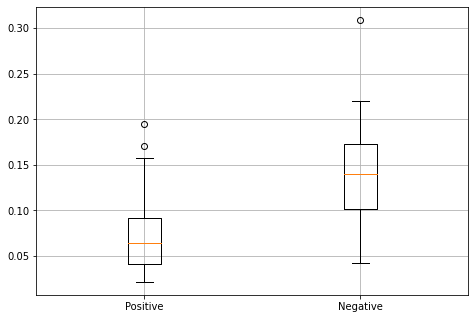

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1, 1])
ax.boxplot([predictions_labels_negative, predictions_labels_positive])
plt.xticks([1, 2], ['Positive', 'Negative'])
ax.grid()
plt.show()

In [ ]:
def compute_accuracy(y_true, y_pred, cutoff):
    pred = y_pred > cutoff
    return np.mean(pred == y_true), pred

In [ ]:
cutoff = (positive_mean + negative_mean)/2

test_accuracy, y_pred = compute_accuracy(test_labels, predictions_for_accuracy, cutoff)
print(f'Accuracy: {test_accuracy*100:.2f}%')

Accuracy: 78.33%


In [ ]:
def visualize(pairs, labels, cutoff, to_show=6, num_col=3, predictions=None, test=False):

    num_row = to_show // num_col if to_show // num_col != 0 else 1

    to_show = num_row * num_col

    fig, axes = plt.subplots(num_row, num_col, figsize=(5, 5))
    for i in range(to_show):

        if num_row == 1:
            ax = axes[i % num_col]
        else:
            ax = axes[i // num_col, i % num_col]

        ax.imshow(tf.concat([cv2.cvtColor(cv2.imread(pairs["left"].iloc[i]), cv2.COLOR_BGR2RGB), cv2.cvtColor(cv2.imread(pairs["right"].iloc[i]), cv2.COLOR_BGR2RGB)], axis=1), cmap="gray")
        ax.set_axis_off()
        if test:
            ax.set_title("True: {} | Pred: {}".format('Same' if labels["label"].iloc[i] == 1 else 'Different',
                                                      'Same' if predictions[i][0] > cutoff else 'Different'))
        else:
            ax.set_title("Label: {}".format(labels[i]))
    if test:
        plt.tight_layout(rect=(0, 0, 1.9, 1.9), w_pad=0.0)
    else:
        plt.tight_layout(rect=(0, 0, 1.5, 1.5))
    plt.show()

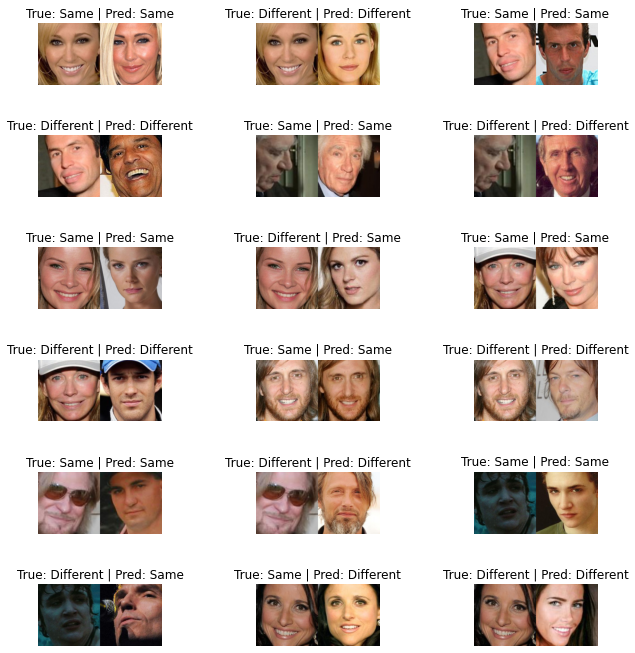

In [ ]:
visualize(X_val, Y_val_label, cutoff, to_show=18, num_col=3, predictions=predictions, test=True)

## Live Demo
Using our photos to extract features and then predicting identity computing the distance metric.

In [ ]:
team_photos_path_left = "drive/MyDrive/Dataset/team_photos_preprepared/"
team_photos_path_right = "drive/MyDrive/Dataset/team_photos_live/"

In [ ]:
team_photos_left = os.listdir(team_photos_path_left)
team_photos_right = os.listdir(team_photos_path_right)

In [ ]:
def get_features_vector(extractor, photos):
  """ Function returns extracted features in a list for each given photo identified by a path. """
  results = []
  processed_photos = map(convert_to_img, photos)
  
  for photo in processed_photos:
    features = extractor.predict(photo)
    results.append(features)

  return results

In [ ]:
team_photos_left_features = get_features_vector(features_extractor, team_photos_left)
team_photos_right_features = get_features_vector(features_extractor, team_photos_right)

In [ ]:
def find_best_match(reference_fv, list_of_fvs):
  best_match = None
  
  for i in range(0, len(list_of_fvs)):
    distance = euclidean_distance((reference_fv, list_of_fvs[i]))
    if not best_match or best_match > distance:
      best_match = distance
    else:
      continue

    return list_of_fvs.index(best_match)